

# **📘 Project Introduction: AI-Driven Algorithmic Trading System**

This project presents a comprehensive AI-driven intraday trading system that integrates real-time news sentiment analysis with time series forecasting to enhance decision-making in financial markets. The system is developed as part of a capstone research initiative by graduate students from the University of Arizona's School of Information.

Focusing on the AI, EV, and ETF sectors, the project leverages Nixtla’s TimeGPT model for short-term price forecasting and uses FinBERT and other open-source NLP models to assess sentiment from real-time financial news. By combining quantitative forecasts with qualitative news insights, the system aims to build an interpretable, data-driven strategy that reflects real-world conditions.

The modular pipeline encompasses data acquisition via `yfinance`, sentiment tagging through NewsAPI headlines, spike/event detection, forecasting, risk control logic, performance tracking, and visualization. It is designed to simulate a real-time intraday trading environment while adhering to ethical and regulatory considerations.

Note: This system is strictly for educational and research purposes and is not intended for deployment in live markets.


# **🧩 Problem Statement**

Intraday traders often face challenges in reacting to rapid market changes and interpreting high-frequency data amidst news volatility. Traditional technical indicators alone are insufficient to capture the nuanced impact of real-time news and market sentiment.

This project addresses the following core problem:

> *"How can we combine time-series forecasting and real-time sentiment analysis to build a reliable, interpretable, and semi-automated intraday trading strategy"*

By integrating TimeGPT for predictive modeling and LLM-based sentiment pipelines, we aim to uncover whether a hybrid model can outperform naive strategies and ETF benchmarks in terms of return consistency, drawdown control, and signal quality.

The outcome is a modular, backtestable, and extensible system capable of evaluating multiple trading hypotheses under controlled, ethical, and data-driven conditions.
"""

In [3]:
# Necessary libraries
#!pip install yfinance
#!pip install newspaper3k
#!pip install transformers torch
#!pip install yfinance
#!pip install chronos-ts --upgrade --quiet
import json

## **Retrieve latest news from NewsAPI**

Pull yesterday’s financial news headlines using NewsAPI for the latest market-moving events

In [4]:
# Code to retrieve yesterday news from NewSAPI.

import requests
import pandas as pd
from datetime import datetime, timedelta

# 🔑 Enter your NewsAPI key here
NEWSAPI_KEY = "c32779e494d04276b24ac0eb577c5ca2"

def fetch_yesterdays_news():
    yesterday = datetime.now() - timedelta(days=1)
    date_str = yesterday.strftime("%Y-%m-%d")

    query = (
    "stocks OR stock OR market OR earnings OR inflation OR layoffs OR fed OR economic data "
    "OR acquisition OR merger OR buyout OR billion OR million OR IPO OR funding "
    "OR forecast OR guidance OR quarterly results OR revenue OR profits OR shares "
    "OR dividends OR buybacks OR takeover OR analysts OR downgrade OR upgrade"
    )

    domains = (
        "bloomberg.com,cnn.com,cnbc.com,wsj.com,reuters.com,marketwatch.com,"
        "yahoo.com,investopedia.com,seekingalpha.com,fool.com,fortune.com,"
        "forbes.com,techcrunch.com,businessinsider.com,barrons.com"
    )

    url = (
        f"https://newsapi.org/v2/everything?q={query}"
        f"&from={date_str}&to={date_str}"
        f"&language=en&sortBy=publishedAt"
        f"&pageSize=100"
        f"&domains={domains}"
        f"&apiKey={NEWSAPI_KEY}"
    )

    response = requests.get(url)
    data = response.json()

    if "articles" in data:
        articles = data["articles"]
        df = pd.DataFrame([{
            "title": article["title"],
            "description": article["description"],
            "publishedAt": article["publishedAt"],
            "source": article["source"]["name"]
        } for article in articles])
        return df
    else:
        print("No articles found or error in API call.")
        return pd.DataFrame()

# 🚀 Run it
news_df = fetch_yesterdays_news()
news_df.to_csv("news_headlines.csv", index=False)
news_df.head(10)  # Preview the headlines



,title,description,publishedAt,source
0,Franchising — A Business Model For Everyone,Discover how franchising provides an opportuni...,2025-04-29T23:56:07Z,Forbes
1,"‘The Eternaut,’ Argentina’s Most Ambitious Sci...",Internationally acclaimed actor Ricardo Darín ...,2025-04-29T23:52:18Z,Forbes
2,The 15 Most Expensive ZIP Codes In New Hampshi...,Looking for the most expensive ZIP codes in Ne...,2025-04-29T23:50:48Z,Forbes
3,Grand Valley State DL Josh Schell transfers to...,Defensive lineman Josh Schell has two seasons ...,2025-04-29T23:50:14Z,Yahoo Entertainment
4,'AMERICAN BETRAYAL'...,'AMERICAN BETRAYAL'...\r\n\n \n \n \n (Top hea...,2025-04-29T23:46:36Z,Yahoo Entertainment
5,Waymo and Toyota are dating. If they get serio...,Waymo and Toyota have agreed to explore a poss...,2025-04-29T23:43:35Z,TechCrunch
6,Adobe analyzes landscape photography subreddit...,None,2025-04-29T23:40:00Z,Yahoo Entertainment
7,Jim Cramer says politicians should not forget ...,CNBC's Jim Cramer on Tuesday expressed that po...,2025-04-29T23:37:37Z,CNBC
8,Where the 'Fast Money' traders see the most pr...,"The ""Fast Money"" traders share their best and ...",2025-04-29T23:34:26Z,CNBC
9,Republicans Advance Student Loan Overhaul With...,The proposal targets eligibility for Pell Gran...,2025-04-29T23:33:16Z,Forbes


## **Extract Tickers from Yesterday’s News**

Identify all the stock tickers mentioned in yesterday’s headlines using NLP

In [5]:
import spacy
nlp = spacy.load("en_core_web_sm")


In [6]:
#Loading company names and tickers
import pandas as pd

def load_sp500_tickers():
    url = "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv"
    df = pd.read_csv(url)

    print("📊 Loaded columns:", df.columns.tolist())  # Debugging

    # Fix column names if needed
    if 'Name' not in df.columns or 'Symbol' not in df.columns:
        if len(df.columns) >= 2:
            df.columns = ['Symbol', 'Name'] + list(df.columns[2:])
        else:
            raise ValueError("CSV does not have expected columns.")

    return {row['Name'].lower(): row['Symbol'] for _, row in df.iterrows()}



In [7]:
# ✅ Named Entity Recognition + Ticker Extraction
def extract_companies_from_articles(news_df, known_companies):
    """
    Extracts company mentions from a DataFrame of news articles and maps them to S&P 500 tickers.

    Args:
        news_df (DataFrame): News articles with 'title' and 'description' columns
        known_companies (dict): Mapping of company names (lowercase) to tickers

    Returns:
        List of matched tickers
    """
    mentioned_tickers = set()
    articles = news_df.to_dict(orient="records")  # ✅ Ensure correct format

    for article in articles:
        text = (article.get("title") or "") + " " + (article.get("description") or "")
        doc = nlp(text)

        for ent in doc.ents:
            if ent.label_ == "ORG":
                company_name = ent.text.lower()
                for known_name, ticker in known_companies.items():
                    if company_name in known_name:  # simple fuzzy match
                        mentioned_tickers.add(ticker)

    return list(mentioned_tickers)

In [8]:
news_df = fetch_yesterdays_news()
known_companies = load_sp500_tickers()

mentioned_tickers = extract_companies_from_articles(news_df, known_companies)
print("🧠 Tickers mentioned in yesterday’s news:", mentioned_tickers)


📊 Loaded columns: ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded']
🧠 Tickers mentioned in yesterday’s news: ['AVB', 'LH', 'FRT', 'PLTR', 'GOOG', 'INTC', 'CRWD', 'NDAQ', 'GOOGL', 'ACN', 'AMZN', 'BX', 'ARE', 'STT', 'ALL', 'FDX', 'NUE', 'PCAR']


## ***Step 3*** — Sentiment Analysis with FinBERT
Analyze sentiment of the headlines (from NewsAPI) and any historical headlines you have using FinBERT, a financial-domain BERT model.

In [9]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from collections import defaultdict

# ✅ Load FinBERT
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

# ✅ Get sentiment for a piece of text
def get_finbert_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).numpy()[0]
    sentiment_idx = np.argmax(probs)
    sentiment_label = ["negative", "neutral", "positive"][sentiment_idx]
    score = probs[sentiment_idx]
    return sentiment_label, float(score)

# ✅ Score sentiment ONLY for tickers from Step 2 (your extracted tickers)
def score_sentiment_for_mentioned_tickers(news_df, known_companies, mentioned_tickers):
    from collections import defaultdict
    import numpy as np
    import pandas as pd

    # 🔄 Reverse map tickers -> company names
    ticker_to_name = {
        ticker: name
        for name, ticker in known_companies.items()
        if ticker in mentioned_tickers
    }

    sentiment_records = defaultdict(list)

    for _, article in news_df.iterrows():
        text = f"{article.get('title', '')} {article.get('description', '')}".lower()
        sentiment, score = get_finbert_sentiment(text)

        for ticker in mentioned_tickers:
            company_name = ticker_to_name.get(ticker, "").lower()
            if ticker.lower() in text or company_name in text:
                sentiment_records[ticker].append((sentiment, score))

    # 📊 Aggregate results
    results = []
    for ticker, records in sentiment_records.items():
        sentiments = [s for s, _ in records]
        scores = [s for _, s in records]
        avg_score = np.mean(scores)

        # 🪵 Debug print (optional)
        print(f"🔍 {ticker} → Avg Sentiment Score: {avg_score:.3f}")

        if avg_score >= 0.98:  # ✅ Only keep perfect scores
            dominant = max(set(sentiments), key=sentiments.count)
            results.append({
                "Ticker": ticker,
                "Mentions": len(records),
                "Avg Sentiment Score": round(avg_score, 3),
                "Dominant Sentiment": dominant
            })

    # 🛡️ Handle empty result
    df = pd.DataFrame(results)
    if not df.empty:
        df = df.sort_values("Mentions", ascending=False).reset_index(drop=True)
    return df


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [10]:
sentiment_df = score_sentiment_for_mentioned_tickers(news_df, known_companies, mentioned_tickers)
sentiment_df.to_csv("sentiment_summary.csv", index=False)
print(sentiment_df)

🔍 ALL → Avg Sentiment Score: 0.983
🔍 ARE → Avg Sentiment Score: 0.971
🔍 LH → Avg Sentiment Score: 1.000
🔍 CRWD → Avg Sentiment Score: 0.998
🔍 NUE → Avg Sentiment Score: 1.000
🔍 INTC → Avg Sentiment Score: 0.788
🔍 AMZN → Avg Sentiment Score: 0.994
  Ticker  Mentions  Avg Sentiment Score Dominant Sentiment
0    ALL        23                0.983           negative
1   AMZN         2                0.994            neutral
2     LH         1                1.000           negative
3   CRWD         1                0.998            neutral
4    NUE         1                1.000           negative


In [11]:
# 📈 Sort by Avg Sentiment Score (descending order)
sentiment_df = sentiment_df.sort_values("Avg Sentiment Score", ascending=False).reset_index(drop=True)

In [12]:
sentiment_df

,Ticker,Mentions,Avg Sentiment Score,Dominant Sentiment
0,LH,1,1.000,negative
1,NUE,1,1.000,negative
2,CRWD,1,0.998,neutral
3,AMZN,2,0.994,neutral
4,ALL,23,0.983,negative


# 🧠 Fetch News (Last 30 Days)

In [13]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# 🔑 Replace this with your actual API key
api_key = "79b7aa20b731467eb7965cced65acc54"

# 📆 Define the time range (last 30 days)
end_date = datetime.now()
start_date = end_date - timedelta(days=30)

# 📰 Topic or stock to search for
query = "nifty50 OR stock market OR NSE India"

# 🌍 Base URL
url = "https://newsapi.org/v2/everything"

# 🧾 Parameters
params = {
    "q": query,
    "from": start_date.strftime('%Y-%m-%d'),
    "to": end_date.strftime('%Y-%m-%d'),
    "sortBy": "publishedAt",
    "language": "en",
    "pageSize": 100,
    "apiKey": api_key,
}

# 📡 Make the request
response = requests.get(url, params=params)
data = response.json()

# ✅ Convert to DataFrame
if data["status"] == "ok":
    articles = data["articles"]
    df = pd.DataFrame([{
        "title": article["title"],
        "publishedAt": article["publishedAt"],
        "description": article["description"],
        "url": article["url"],
        "source": article["source"]["name"]
    } for article in articles])

    print(f"✅ Retrieved {len(df)} news articles.")
    print(df.head())
    # Optional: Save to CSV
    df.to_csv("newsapi_last_30_days.csv", index=False)
else:
    print(f"❌ Error: {data.get('message')}")


✅ Retrieved 100 news articles.
                                               title           publishedAt  \
0  At BRICS Summit, Brazil Warns Against Protecti...  2025-04-29T23:42:49Z   
1  Maharashtra tops state rankings with strong fi...  2025-04-29T23:37:01Z   
2     Kokuyo to buy office furniture maker HNI India  2025-04-29T23:34:59Z   
3          Beware of opinion trading platforms: Sebi  2025-04-29T23:30:12Z   
4  30% private companies plan to invest in upgrad...  2025-04-29T23:26:39Z   

                                         description  \
0  Foreign ministers from the BRICS group of deve...   
1  India-Business News: MUMBAI: Maharashtra emerg...   
2  India-Business News: MUMBAI: Japan's Kokuyo, w...   
3  India-Business News: MUMBAI: Markets regulator...   
4  India-Business News: New Delhi: About 30% of f...   

                                                 url              source  
0  https://www.ndtv.com/world-news/at-brics-summi...           NDTV News  
1  https://ti

In [14]:
# Fetch only the top 3 tickers with highest sentiment score from sentiment_df

# 📌 Sort by Avg Sentiment Score (descending) and pick top 3
top3_tickers_df = sentiment_df.sort_values("Avg Sentiment Score", ascending=False).head(3)

# 📌 Extract the Ticker list
tickers_to_fetch = top3_tickers_df["Ticker"].dropna().unique().tolist()

print(f"🎯 Top 3 Tickers Selected for Price Fetching: {tickers_to_fetch}")

🎯 Top 3 Tickers Selected for Price Fetching: ['LH', 'NUE', 'CRWD']


In [15]:
tickers_to_fetch

['LH', 'NUE', 'CRWD']

##***Step 4*** — Fetch historical price data for these tickers using yfinance

Fetch daily stock price data for the tickers extracted from yesterday’s news (sentiment_df) using yfinance, covering the past 5 years.



In [16]:
import os
import pandas as pd
import yfinance as yf

# ✅ This function: Load CSV if exists, else fetch from Yahoo Finance
def load_or_fetch_historical_data(ticker, years=5):
    filename = f"historical_price_data_top3/{ticker}_price_history.csv"
    if os.path.exists(filename):
        print(f"📂 Loading existing historical data for {ticker}")
        df = pd.read_csv(filename)
    else:
        print(f"⬇️ Fetching new data for {ticker} (not found locally)")
        end = pd.Timestamp.today()
        start = end - pd.DateOffset(years=years)
        df = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), progress=False)
        df.reset_index(inplace=True)
        df = df[["Date", "Close"]].rename(columns={"Close": "Price"})
        os.makedirs("historical_price_data_top3", exist_ok=True)
        df.to_csv(filename, index=False)
    return df

# 📦 Load/Fecth Historical Data for Top 3
historical_data = {}

for ticker in tickers_to_fetch:
    historical_data[ticker] = load_or_fetch_historical_data(ticker)

# 👀 Display head(5) for each ticker
for ticker, df in historical_data.items():
    print(f"\n📈 {ticker} - First 5 Rows of Historical Data:\n")
    print(df.head(5))


⬇️ Fetching new data for LH (not found locally)
YF.download() has changed argument auto_adjust default to True
⬇️ Fetching new data for NUE (not found locally)
⬇️ Fetching new data for CRWD (not found locally)

📈 LH - First 5 Rows of Historical Data:

Price        Date       Price
Ticker                     LH
0      2020-04-30  136.070084
1      2020-05-01  131.585403
2      2020-05-04  130.443573
3      2020-05-05  134.663452
4      2020-05-06  131.643326

📈 NUE - First 5 Rows of Historical Data:

Price        Date      Price
Ticker                   NUE
0      2020-04-30  37.540459
1      2020-05-01  37.367298
2      2020-05-04  37.421989
3      2020-05-05  37.139450
4      2020-05-06  36.911606

📈 CRWD - First 5 Rows of Historical Data:

Price        Date      Price
Ticker                  CRWD
0      2020-04-30  67.660004
1      2020-05-01  69.209999
2      2020-05-04  73.430000
3      2020-05-05  71.589996
4      2020-05-06  72.440002


## ***Step 5*** - Forecast for next 1 Week with TimeGPT

In [17]:
# ✅ INSTALL (if not done)
!pip install nixtla --quiet
!pip install utilsforecast --quiet
!pip install yfinance matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00


In [18]:
# ✅ IMPORTS
import yfinance as yf
import pandas as pd
from nixtla import NixtlaClient
from utilsforecast.preprocessing import fill_gaps
import matplotlib.pyplot as plt
import os

In [19]:
# ✅ Setup TimeGPT Client
client = NixtlaClient(api_key="nixak-Cy1l2cVcBmGLFNxQGpF6g8XLJTWBUpVY3CIuZ4aKHaU2of7h7c6SRj0UD77hjR86HHdeYw06d05JIhbB")  # your key


In [20]:
# ✅ Imports already done above
# ✅ Assume TimeGPT client is already connected
# ✅ Assume tickers_to_fetch is already defined (like ['COP', 'IRM', 'NOC'])

# ✅ Updated and Correct Forecasting Function
def forecast_from_existing_csv(ticker, horizon=5):
    print(f"\n🔍 Processing {ticker}...")

    path = f"historical_price_data_top3/{ticker}_price_history.csv"
    if not os.path.exists(path):
        print(f"❌ File not found for {ticker}. Skipping.")
        return None

    # 📂 Step 1: Load CSV
    df = pd.read_csv(path)

    # 🧹 Step 2: Drop the first junk row
    df = df.drop(index=0).reset_index(drop=True)

    # 🧹 Step 3: Rename columns
    df = df.rename(columns={"Date": "ds", "Price": "y"})

    # 🧹 Step 4: Force 'y' to numeric type
    df['y'] = pd.to_numeric(df['y'], errors='coerce')

    # 🧹 Step 5: Drop any remaining NaN
    df = df.dropna(subset=["ds", "y"])

    # 🧹 Step 6: Datetime conversion
    df['ds'] = pd.to_datetime(df['ds'])

    # 🧹 Step 7: Add unique_id column for TimeGPT
    df['unique_id'] = ticker
    df = df[['unique_id', 'ds', 'y']]

    # 🧹 Step 8: Fill missing dates and interpolate
    df_filled = fill_gaps(df, freq='D')
    df_filled['y'] = df_filled['y'].interpolate(method='linear', limit_direction='both')

    # 🔮 Step 9: Forecast using TimeGPT
    forecast_df = client.forecast(
        df=df_filled,
        h=horizon,
        freq='D',
        model='timegpt-1'
    )

    # ✅ Return forecasted DataFrame
    return forecast_df

# ✅ Now run for all tickers
forecasts = {}

for ticker in tickers_to_fetch:
    forecast_df = forecast_from_existing_csv(ticker)
    forecasts[ticker] = forecast_df

    # ✅ Print the forecasted values
    if forecast_df is not None:
        print(f"\n📈 Forecasted values for {ticker}:\n")
        print(forecast_df)



🔍 Processing LH...

📈 Forecasted values for LH:

  unique_id         ds    TimeGPT
0        LH 2025-04-30  237.66112
1        LH 2025-05-01  234.49107
2        LH 2025-05-02  232.68774
3        LH 2025-05-03  231.86473
4        LH 2025-05-04  231.99069

🔍 Processing NUE...

📈 Forecasted values for NUE:

  unique_id         ds     TimeGPT
0       NUE 2025-04-30  119.058830
1       NUE 2025-05-01  117.557205
2       NUE 2025-05-02  116.044970
3       NUE 2025-05-03  115.417690
4       NUE 2025-05-04  115.008060

🔍 Processing CRWD...

📈 Forecasted values for CRWD:

  unique_id         ds    TimeGPT
0      CRWD 2025-04-30  439.99326
1      CRWD 2025-05-01  437.85470
2      CRWD 2025-05-02  433.38492
3      CRWD 2025-05-03  431.39923
4      CRWD 2025-05-04  428.33966



📊 Plotting LH...


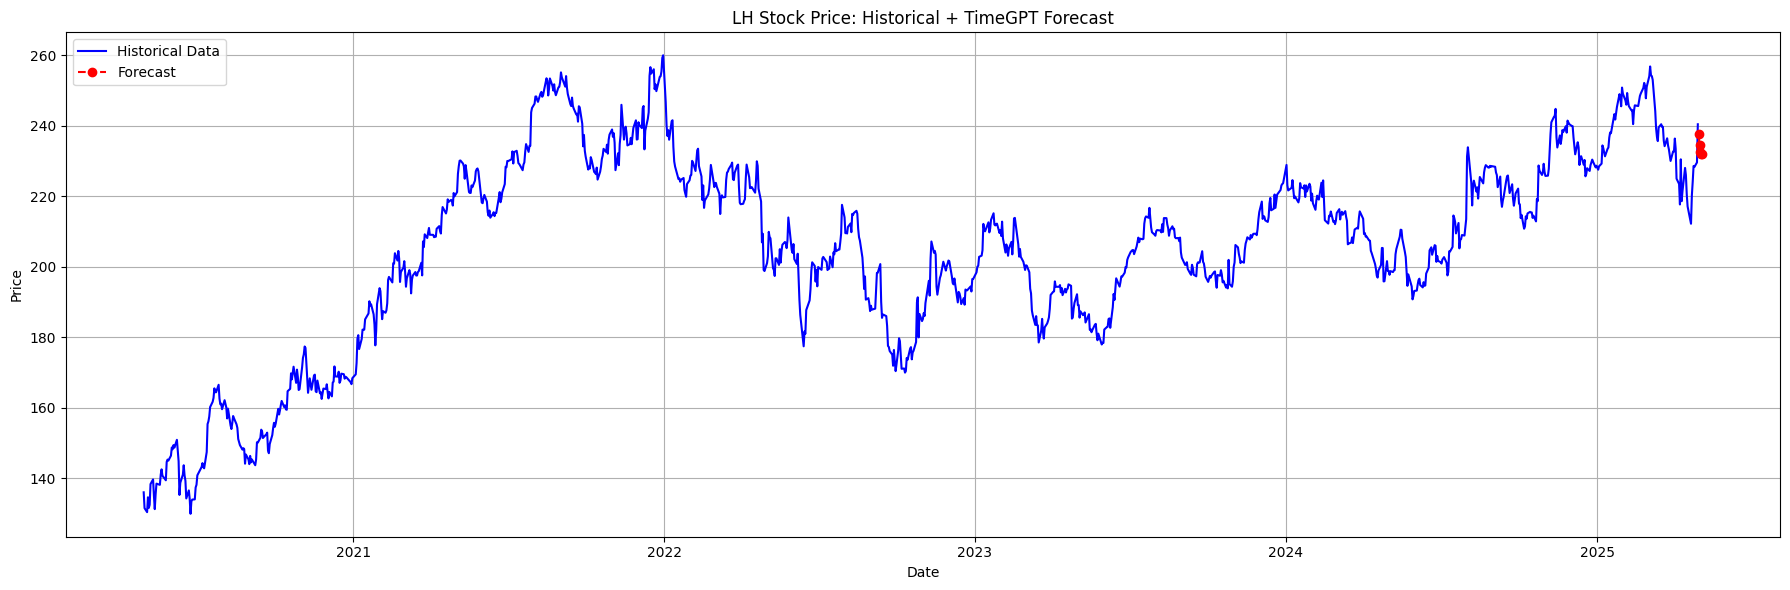


📊 Plotting NUE...


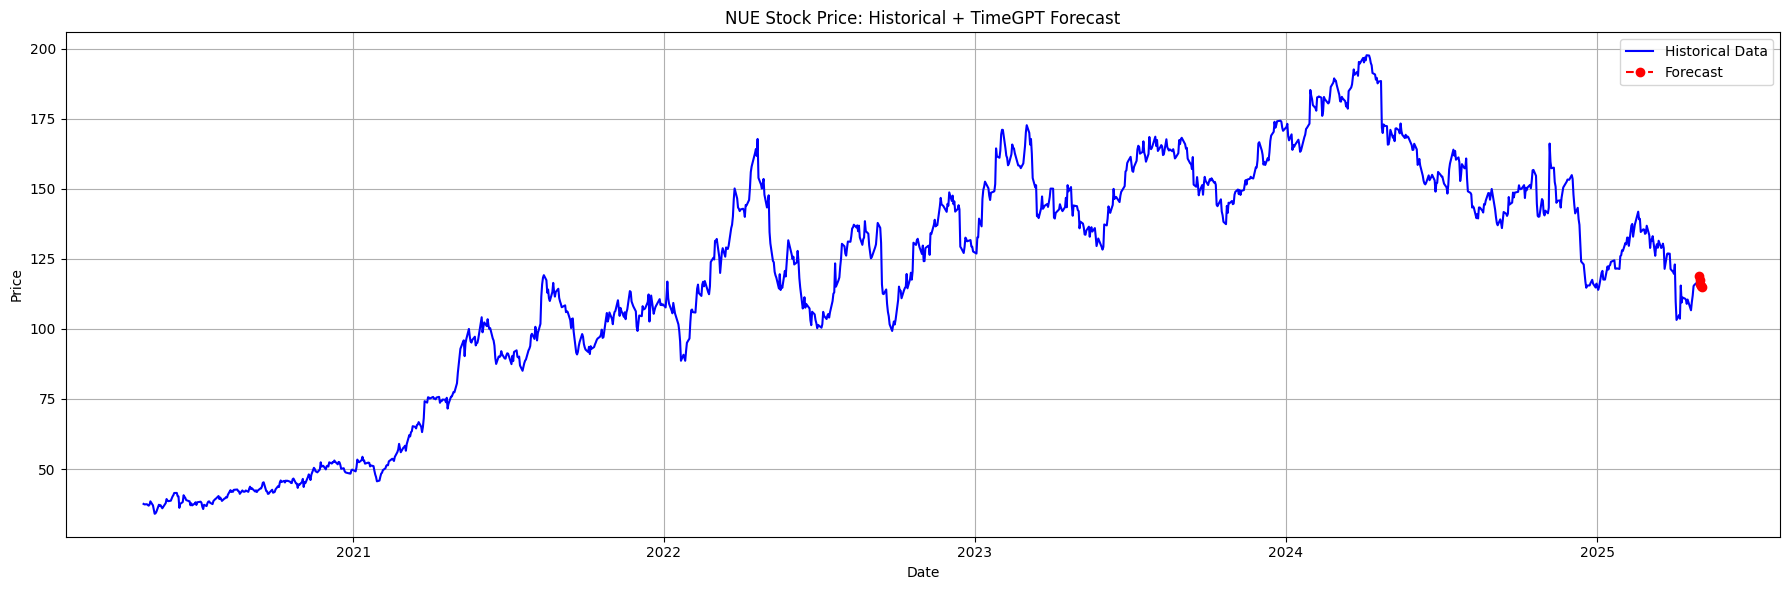


📊 Plotting CRWD...


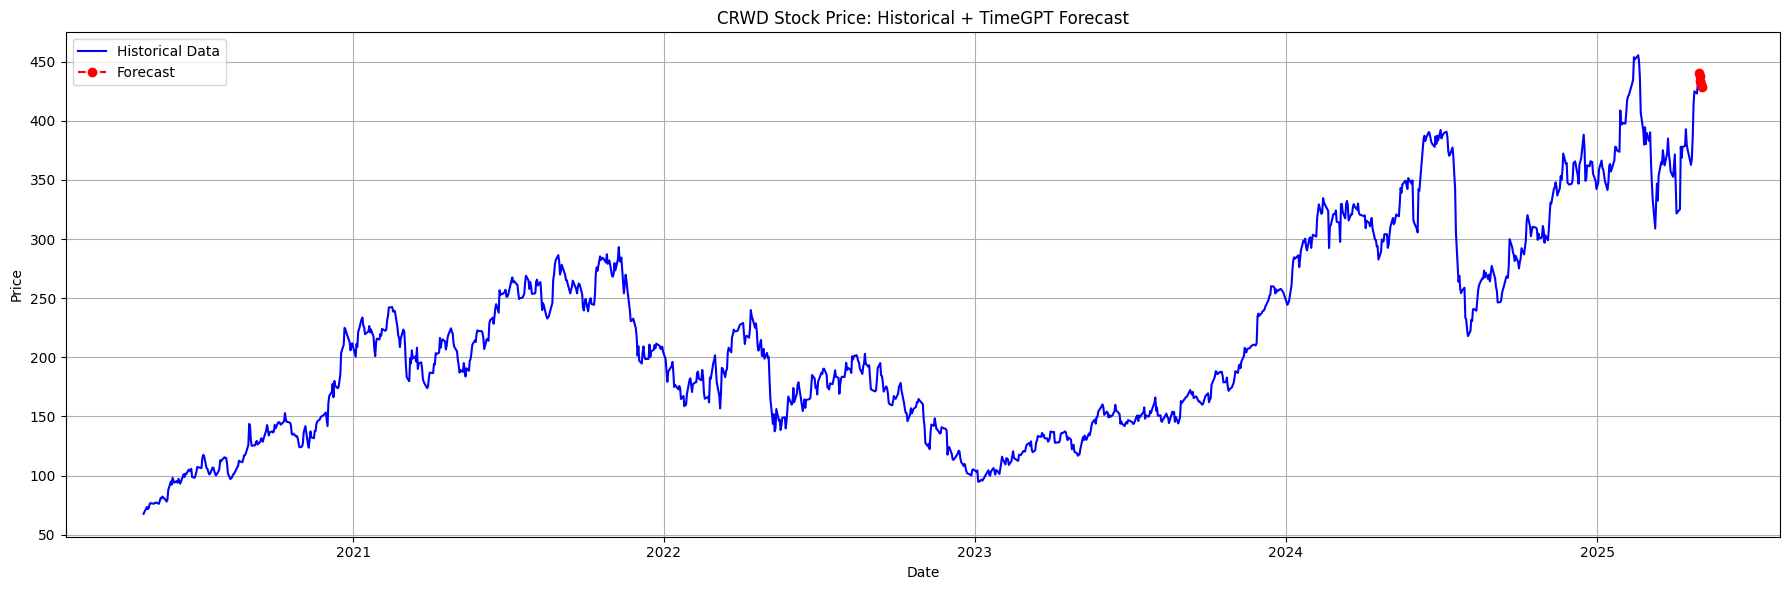

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# ✅ New plotting function
def plot_historical_and_forecast(ticker, historical_folder="historical_price_data_top3/", forecast_horizon=5):
    print(f"\n📊 Plotting {ticker}...")

    # Load Historical CSV
    historical_path = os.path.join(historical_folder, f"{ticker}_price_history.csv")
    if not os.path.exists(historical_path):
        print(f"❌ Historical data not found for {ticker}. Skipping.")
        return

    hist_df = pd.read_csv(historical_path)

    # Drop junk first row
    hist_df = hist_df.drop(index=0).reset_index(drop=True)

    # Rename columns
    hist_df = hist_df.rename(columns={"Date": "ds", "Price": "y"})

    # Force y to numeric
    hist_df['y'] = pd.to_numeric(hist_df['y'], errors='coerce')
    hist_df = hist_df.dropna(subset=["ds", "y"])

    # Convert ds to datetime
    hist_df['ds'] = pd.to_datetime(hist_df['ds'])

    # Get forecasted data from dictionary
    forecast_df = forecasts.get(ticker)
    if forecast_df is None:
        print(f"❌ No forecast available for {ticker}. Skipping plot.")
        return

    # Create plot
    plt.figure(figsize=(18,6))

    # Plot historical
    plt.plot(hist_df['ds'], hist_df['y'], label='Historical Data', color='blue')

    # Plot forecasted (join from end of historical)
    plt.plot(forecast_df['ds'], forecast_df['TimeGPT'], label='Forecast', color='red', linestyle='--', marker='o')

    # Styling
    plt.title(f'{ticker} Stock Price: Historical + TimeGPT Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()

# ✅ Now plot for all tickers
for ticker in tickers_to_fetch:
    plot_historical_and_forecast(ticker)


## **Calculating Z-Score**

In [22]:
import numpy as np

# ✅ Define function to calculate Z-Scores, Absolute Error, Confidence Intervals
def calculate_forecast_metrics(ticker, historical_folder="historical_price_data_top3/"):
    print(f"\n📈 Calculating metrics for {ticker}...")

    # Load historical data
    hist_path = os.path.join(historical_folder, f"{ticker}_price_history.csv")
    if not os.path.exists(hist_path):
        print(f"❌ Historical data missing for {ticker}. Skipping metrics.")
        return None

    hist_df = pd.read_csv(hist_path)
    hist_df = hist_df.drop(index=0).reset_index(drop=True)
    hist_df = hist_df.rename(columns={"Date": "ds", "Price": "y"})
    hist_df['y'] = pd.to_numeric(hist_df['y'], errors='coerce')
    hist_df = hist_df.dropna(subset=["ds", "y"])
    hist_df['ds'] = pd.to_datetime(hist_df['ds'])

    # Load forecast
    forecast_df = forecasts.get(ticker)
    if forecast_df is None:
        print(f"❌ No forecast available for {ticker}. Skipping metrics.")
        return None

    # ✅ Step 1: Calculate Historical Mean and Std Dev
    mean_y = hist_df['y'].mean()
    std_y = hist_df['y'].std()

    # ✅ Step 2: Z-Score for each forecasted value
    forecast_df['z_score'] = (forecast_df['TimeGPT'] - mean_y) / std_y

    # ✅ Step 3: Absolute Error compared to last actual historical point
    last_actual = hist_df['y'].iloc[-1]
    forecast_df['absolute_error'] = np.abs(forecast_df['TimeGPT'] - last_actual)

    # ✅ Step 4: Confidence Intervals (assuming normal distribution)
    ci_80 = 1.28 * std_y  # 80% confidence
    ci_90 = 1.64 * std_y  # 90% confidence
    ci_95 = 1.96 * std_y  # 95% confidence

    forecast_df['lower_95'] = forecast_df['TimeGPT'] - ci_95
    forecast_df['upper_95'] = forecast_df['TimeGPT'] + ci_95

    forecast_df['lower_90'] = forecast_df['TimeGPT'] - ci_90
    forecast_df['upper_90'] = forecast_df['TimeGPT'] + ci_90

    forecast_df['lower_80'] = forecast_df['TimeGPT'] - ci_80
    forecast_df['upper_80'] = forecast_df['TimeGPT'] + ci_80

    # ✅ Done
    return forecast_df

# ✅ Now run it for all tickers
forecast_with_metrics = {}

for ticker in tickers_to_fetch:
    forecast_metrics_df = calculate_forecast_metrics(ticker)
    forecast_with_metrics[ticker] = forecast_metrics_df

    if forecast_metrics_df is not None:
        print(f"\n📈 Forecast + Metrics for {ticker}:\n")
        print(forecast_metrics_df[['ds', 'TimeGPT', 'z_score', 'absolute_error', 'lower_95', 'upper_95']])



📈 Calculating metrics for LH...

📈 Forecast + Metrics for LH:

          ds    TimeGPT   z_score  absolute_error    lower_95    upper_95
0 2025-04-30  237.66112  1.180430        2.758878  184.016198  291.306042
1 2025-05-01  234.49107  1.064607        5.928928  180.846148  288.135992
2 2025-05-02  232.68774  0.998720        7.732258  179.042818  286.332662
3 2025-05-03  231.86473  0.968650        8.555268  178.219808  285.509652
4 2025-05-04  231.99069  0.973252        8.429308  178.345768  285.635612

📈 Calculating metrics for NUE...

📈 Forecast + Metrics for NUE:

          ds     TimeGPT   z_score  absolute_error   lower_95    upper_95
0 2025-04-30  119.058830  0.006636        0.288833  35.719058  202.398602
1 2025-05-01  117.557205 -0.028679        1.212792  34.217433  200.896977
2 2025-05-02  116.044970 -0.064244        2.725027  32.705198  199.384742
3 2025-05-03  115.417690 -0.078997        3.352307  32.077918  198.757462
4 2025-05-04  115.008060 -0.088631        3.761937  31.6

## **Superposed Epoch Analysis**

In [32]:
def detect_top_spikes(df, top_n=3):
    df = df.copy()
    df['ds'] = pd.to_datetime(df['ds'])
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df = df.dropna(subset=['y'])
    df['return'] = df['y'].pct_change()
    df['z_score'] = (df['return'] - df['return'].mean()) / df['return'].std()
    top_spikes = df.reindex(df['z_score'].abs().sort_values(ascending=False).index).dropna().head(top_n)
    return top_spikes['ds'].tolist()


In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_sea_around_spikes(df, spike_dates, days_before=3, days_after=3, ticker='[Ticker]'):
    df['ds'] = pd.to_datetime(df['ds'])
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df = df.dropna(subset=["ds", "y"])

    for event_date in spike_dates:
        start = event_date - pd.Timedelta(days=days_before)
        end = event_date + pd.Timedelta(days=days_after)
        window = df[(df['ds'] >= start) & (df['ds'] <= end)].copy()

        required_len = days_before + days_after + 1
        if len(window) < int(0.6 * required_len):  # ✅ Only need 60% of the window
            print(f"⚠️ Skipping spike on {event_date.date()} (only {len(window)} of {required_len} days)")
            continue

        # Align by days relative to spike
        window['epoch_day'] = (window['ds'] - event_date).dt.days
        window.set_index('epoch_day', inplace=True)

        # Plot SEA
        plt.figure(figsize=(10, 5))
        plt.plot(window.index, window['y'], marker='o', linestyle='-', color='blue')
        plt.axvline(0, color='red', linestyle='--', label='Spike')
        plt.title(f"SEA Around Detected Spike on {event_date.date()} [{ticker}]")
        plt.xlabel("Days Around Spike")
        plt.ylabel("Price")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


In [42]:
def auto_sea_for_tickers(tickers, historical_dir="historical_price_data_top3", top_n=3, days_window=5):
    for ticker in tickers:
        print(f"\n📊 SEA for top {top_n} spikes in {ticker}...")

        hist_path = f"{historical_dir}/{ticker}_price_history.csv"
        if not os.path.exists(hist_path):
            print("❌ File not found.")
            continue

        try:
            df = pd.read_csv(hist_path).drop(index=0).rename(columns={"Date": "ds", "Price": "y"})
        except Exception as e:
            print(f"❌ Failed to load {ticker}: {e}")
            continue

        spike_dates = detect_top_spikes(df, top_n=top_n)
        print(f"📌 Detected spikes:")
        for d in spike_dates:
            print("  -", d.date())

        plot_sea_around_spikes(df, spike_dates, days_before=days_window, days_after=days_window, ticker=ticker)



📊 SEA for top 3 spikes in LH...
📌 Detected spikes:
  - 2024-08-01
  - 2020-11-09
  - 2020-06-11


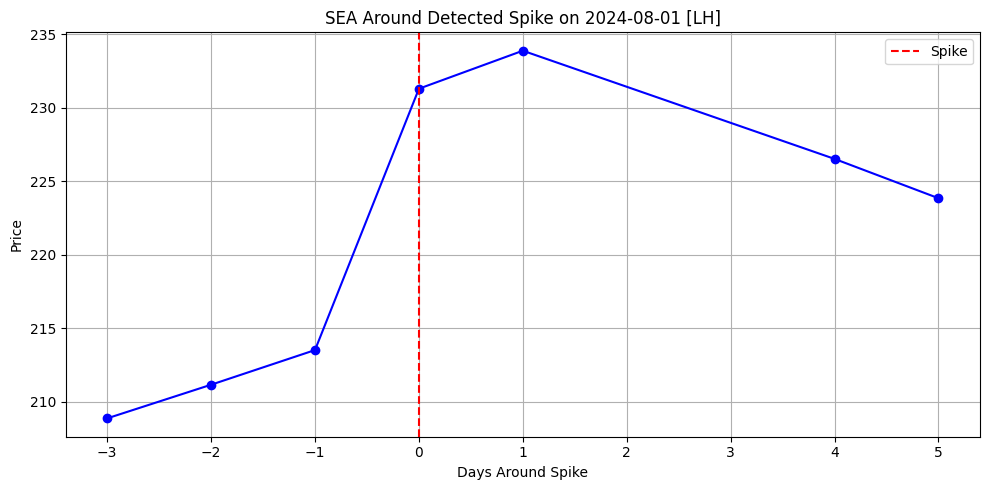

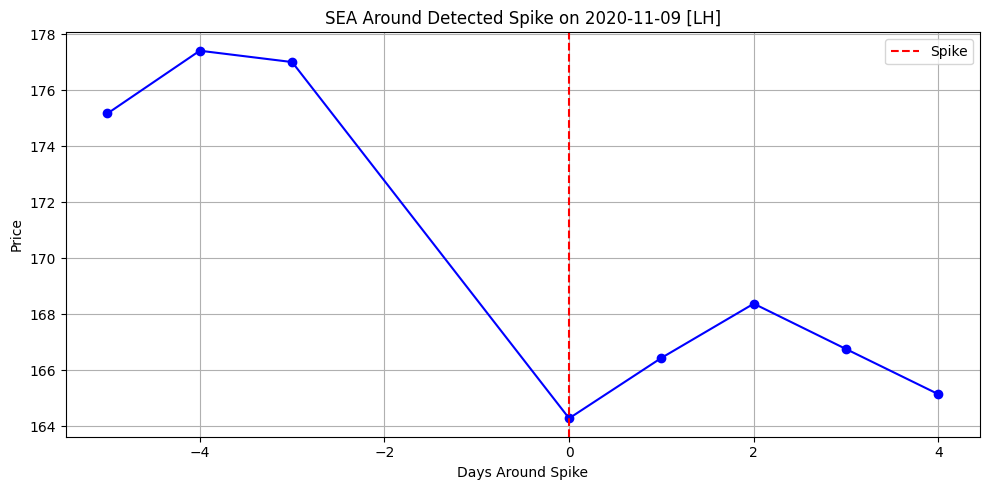

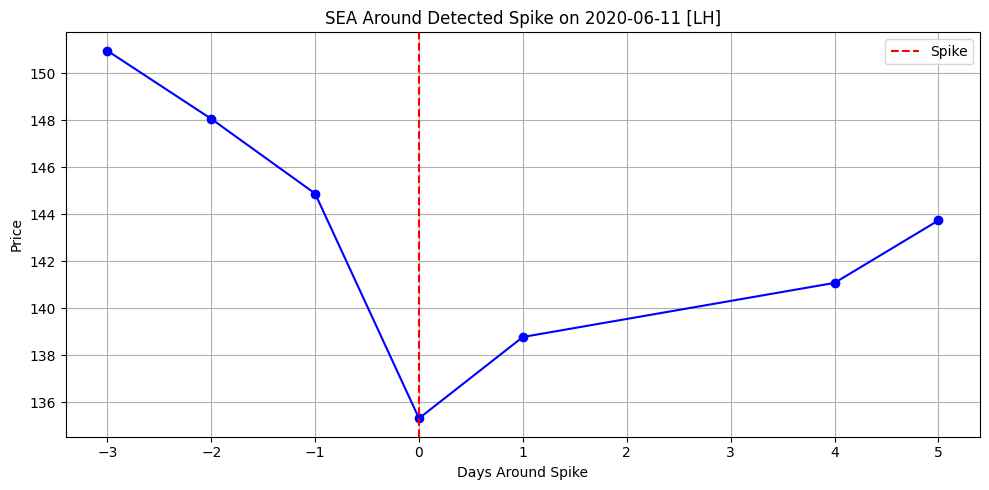


📊 SEA for top 3 spikes in NUE...
📌 Detected spikes:
  - 2024-11-06
  - 2022-09-14
  - 2025-04-09


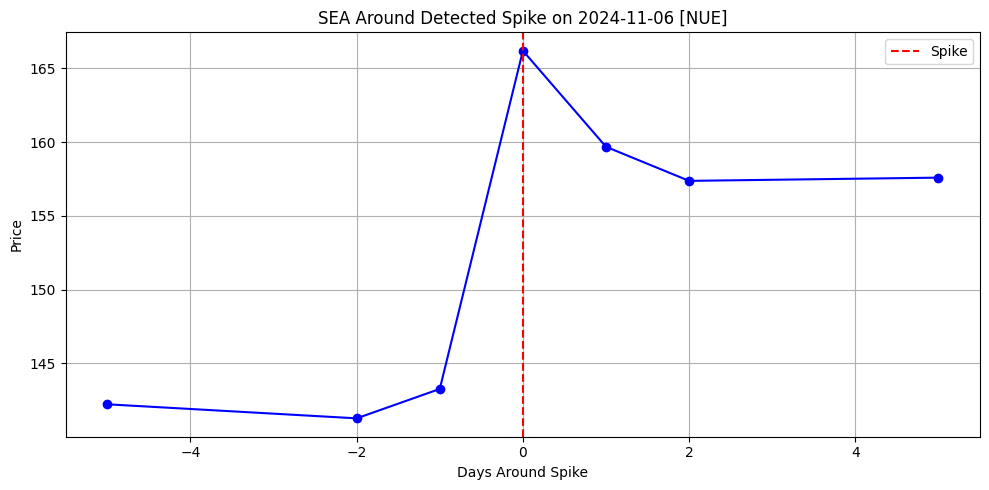

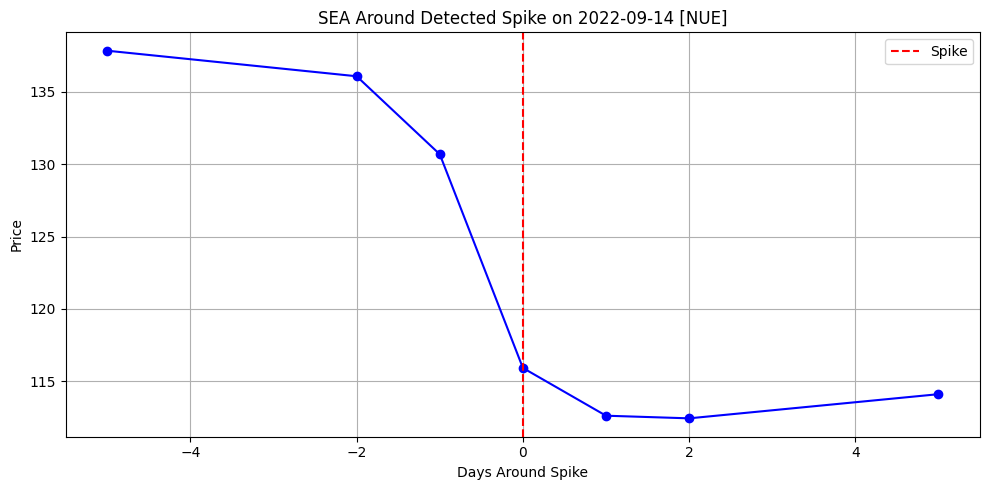

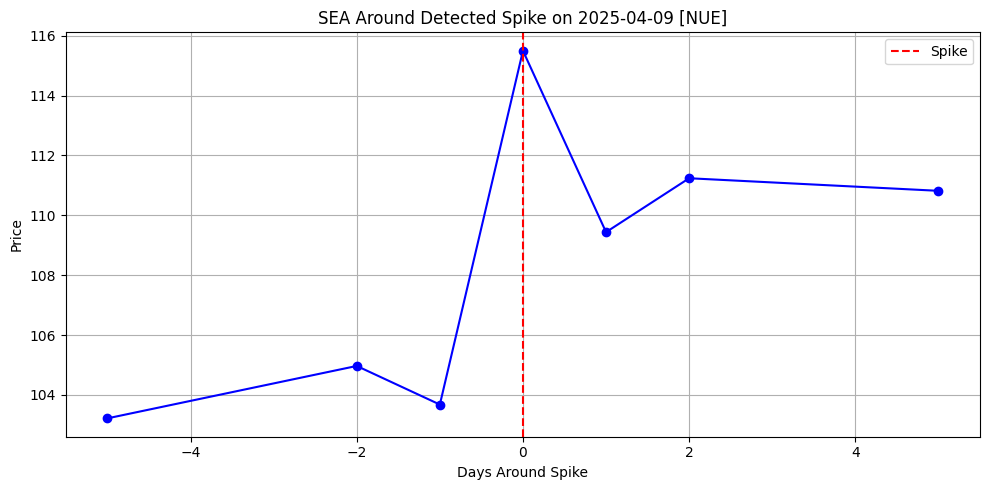


📊 SEA for top 3 spikes in CRWD...
📌 Detected spikes:
  - 2025-04-09
  - 2022-11-30
  - 2020-09-01


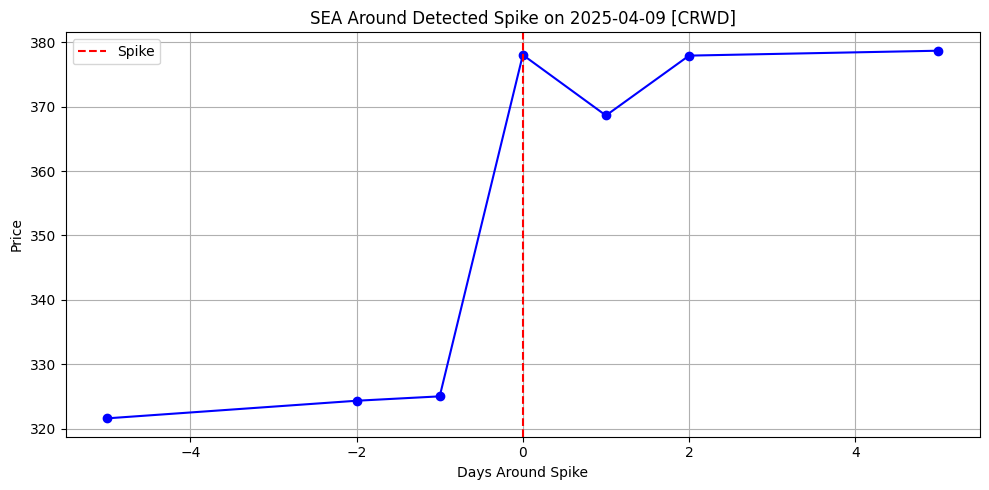

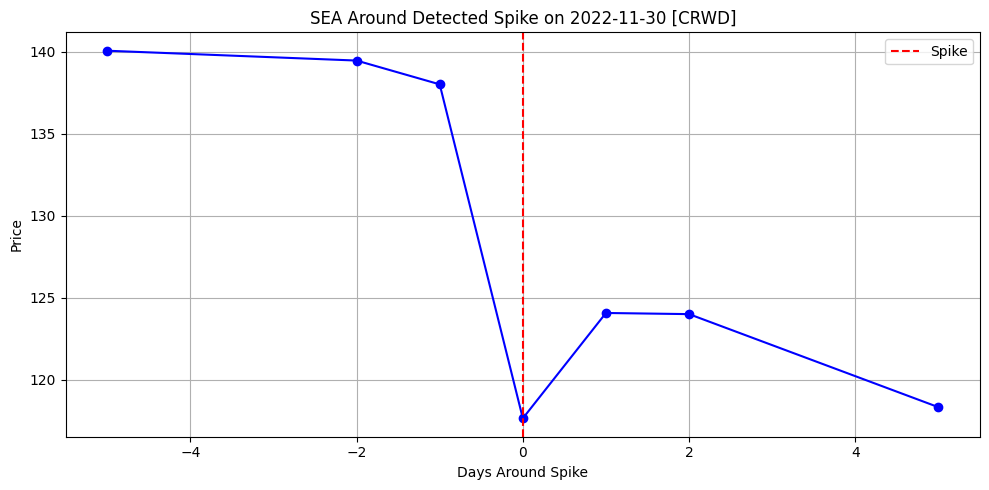

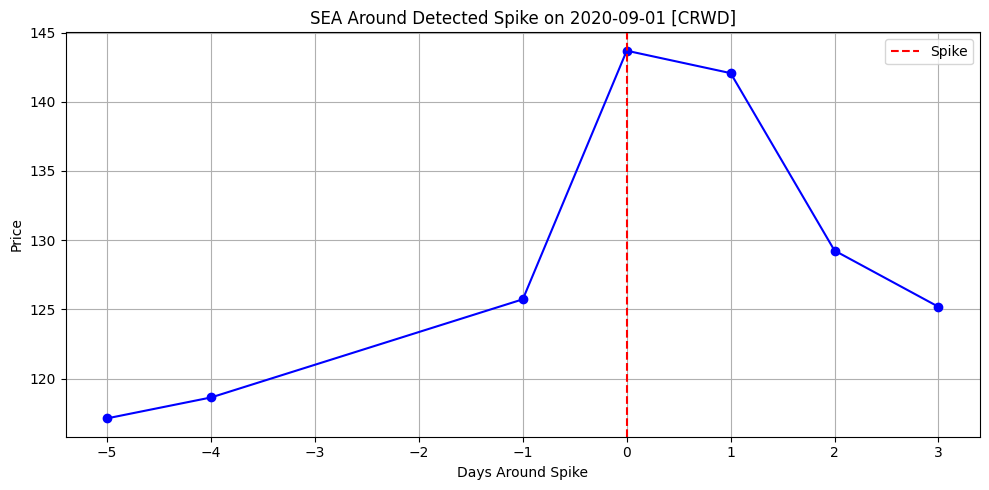

In [43]:
auto_sea_for_tickers(tickers_to_fetch, top_n=3, days_window=5)
